# **Reinforcement Learning: Final Project**
### Elain Balderas, Nina McClure, Nicole Poynarova

#### **Set up**

In [ ]:
### Install required modules
!pip install "stable_baselines3[extra]>=2.0.0a9"
!pip install tensorboard

In [ ]:
### Mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/data

In [ ]:
### Import modules
import gymnasium
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import base64
from pathlib import Path
from IPython import display as ipythondisplay
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

#### **Space Invaders**

**Game objective**: Destroy the space invaders by shooting your laser cannon at them before they reach the Earth. The game ends when all your lives are lost after taking enemy fire, or when they reach the earth.


**Properties of the game**:

*Action space*: a discrete action space with 6 possible actions:

*   Action 0: NOOP (No operation) - The agent does nothing
*   Action 1: FIRE - The agent fires a missile.
*   Action 2: RIGHT - The agent moves the spaceship to the right.
*   Action 3: LEFT - The agent moves the spaceship to the left.
*   Action 4: RIGHTFIRE - The agent moves the spaceship to the right and fires a missile simultaneously.
*   Action 5: LEFTFIRE - The agent moves the spaceship to the left and fires a missile simultaneously.

*Rewards*: You gain points for destroying space invaders. The invaders in the back rows are worth more points. The space invaders are worth 5, 10, 15, 20, 25, 30 points in the first through sixth rows respectively.


Documentation: https://atariage.com/manual_html_page.php?SoftwareLabelID=460


In [4]:
### Create Space Invaders environment
env = make_atari_env("ALE/SpaceInvaders-v5")

Here we use the **Proximal Policy Optimization (PPO)** algorithm.

PPO uses 'clipping' to avoid policy updates that are "too large". Why? A large step in a policy update can lead to instability and result in falling “off the cliff” (getting a bad policy) and taking a long time to recover from the bad policy.

PPO is an on-policy method. The data collected during training is used only for a single iteration of policy update. The agent interacts with the environment, collects data and uses this data to update its policy. The collected data is then discarded, and the process is repeated to collect new data for the next policy update.


**High-level description of the algorithm steps:**

1)  Initialize the policy network and value parameters

2)  Generate a trajectory given the current policy

3)  Compute "advantages": Estimate the "advantages" of each state-action pair in the generated trajectory. (The advantage estimator estimates how much better/worse an action is compared to the average action taken from a given state. It helps in updating the policy towards more rewarding actions.)

4) Define the policy improvement objective function, applying "clipping" to the importance weights. (Importance weights: These weights capture how much the action probabilities (for a given state) have changed between the old and new policies.). Clipping prevents overly large policy updates.

5) Compute the policy gradient and update the policy network's weights via SGD

6) Update the value paramters via TD($λ$)

7) Repeat steps 2) to 6) until convergence




**PPO parameters:**

*   *policy*: The policy model to use. (We use a convolutional neural network)
*   

In [ ]:
### Train model

# Where to store training log
log_dir = 'atari_train_log'

# Instantiate model
model = PPO(policy = 'CnnPolicy', env, verbose=1, tensorboard_log = log_dir)

# Train
model.learn(total_timesteps= 500000, progress_bar = True)
model.save("ppo_model_500k")

  31% ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153,590/500,000  [ 0:18:59 < 0:41:37 , 139 it/s ]

In [6]:
### Load the TensorBoard event files

event_file = log_dir + '/PPO_3'
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Get the list of available tags (summary keys)
#tags = event_acc.Tags()

# Retrieve the training episode rewards from the event files
episode_rewards = event_acc.Scalars('rollout/ep_rew_mean') # mean episode rewards
step = [episode.step for episode in episode_rewards]
reward = [episode.value for episode in episode_rewards]

Text(0, 0.5, 'Mean Episode Reward')

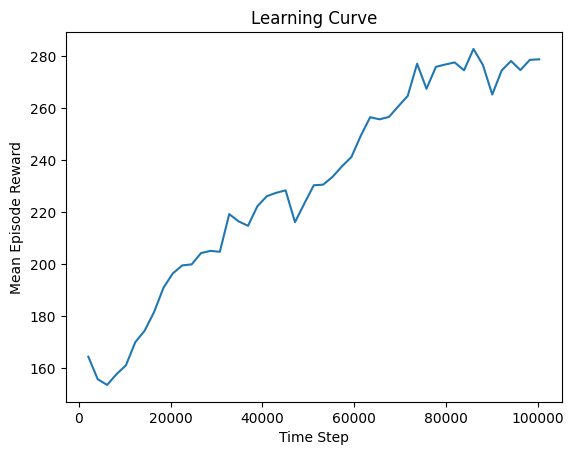

In [7]:
### Plot the learning curve
plt.plot(step, reward)
plt.title('Learning Curve')
plt.xlabel('Time Step')
plt.ylabel('Mean Episode Reward')

In [69]:
#model = model.load("/content/drive/MyDrive/data/ppo_model1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
### Functions to record video
def show_videos(video_path="", prefix=""):
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_video(vec_env, model,fps, video_length=500, prefix="", video_folder="videos/"):
   # Start the video at step=0 and record 500 steps
    vec_env.metadata["render_fps"] = fps
    vec_env = VecVideoRecorder(
        vec_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix
    )

    obs = vec_env.reset()
    for _ in range(video_length):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)

    # Close the video recorder
    vec_env.close()

In [10]:
record_video(env, model,fps = 20, video_length=1000, prefix="ppo-1")
show_videos("videos", prefix="ppo-1")

Saving video to /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4


In [ ]:
# # Load trained model
# env = make_atari_env("ALE/SpaceInvaders-v5")
# #model = PPO.load("ppo_model1")
# model = PPO('CnnPolicy', env)

# # Reset the environment and get the initial observation
# obs = env.reset()

# done = False
# total_reward = 0

# while not done:
#     # Get the action from the model
#     action, _ = model.predict(obs)

#     # Take the action in the environment
#     obs, reward, done, info = env.step(action)
#     print(reward)

#     # Accumulate the reward
#     total_reward += reward

# # Print the score
# print("Score:", total_reward)


In [ ]:
env = make_atari_env("ALE/SpaceInvaders-v5")
#model = PPO.load("ppo_model1") # trained model
model = PPO('CnnPolicy',env) # untrained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")